In [2]:
pip install numpy pandas scikit-learn shap tensorflow keras xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as no
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import shap
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Concatenate
from keras.models import Model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats

In [5]:
train= pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/bank churn/train.csv')
test = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/bank churn/test.csv')

In [6]:
df = pd.concat([train,test], axis=0)
df.shape

(275057, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275057 entries, 0 to 110022
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               275057 non-null  int64  
 1   CustomerId       275057 non-null  int64  
 2   Surname          275057 non-null  object 
 3   CreditScore      275057 non-null  int64  
 4   Geography        275057 non-null  object 
 5   Gender           275057 non-null  object 
 6   Age              275057 non-null  float64
 7   Tenure           275057 non-null  int64  
 8   Balance          275057 non-null  float64
 9   NumOfProducts    275057 non-null  int64  
 10  HasCrCard        275057 non-null  float64
 11  IsActiveMember   275057 non-null  float64
 12  EstimatedSalary  275057 non-null  float64
 13  Exited           165034 non-null  float64
dtypes: float64(6), int64(5), object(3)
memory usage: 31.5+ MB


In [8]:
print(df.describe())

                  id    CustomerId    CreditScore            Age  \
count  275057.000000  2.750570e+05  275057.000000  275057.000000   
mean   137528.000000  1.569204e+07     656.484939      38.124415   
std     79402.260834  7.151271e+04      80.188100       8.864927   
min         0.000000  1.556570e+07     350.000000      18.000000   
25%     68764.000000  1.563300e+07     597.000000      32.000000   
50%    137528.000000  1.569017e+07     659.000000      37.000000   
75%    206292.000000  1.575688e+07     710.000000      42.000000   
max    275056.000000  1.581569e+07     850.000000      92.000000   

              Tenure        Balance  NumOfProducts      HasCrCard  \
count  275057.000000  275057.000000  275057.000000  275057.000000   
mean        5.010867   55420.296450       1.554002       0.753589   
std         2.806173   62805.933171       0.546178       0.430921   
min         0.000000       0.000000       1.000000       0.000000   
25%         3.000000       0.000000       

In [9]:
selected_data = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"]
data = df[selected_data]

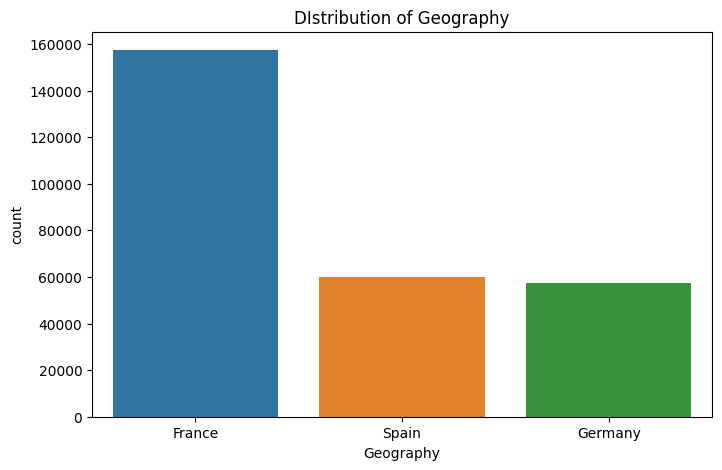

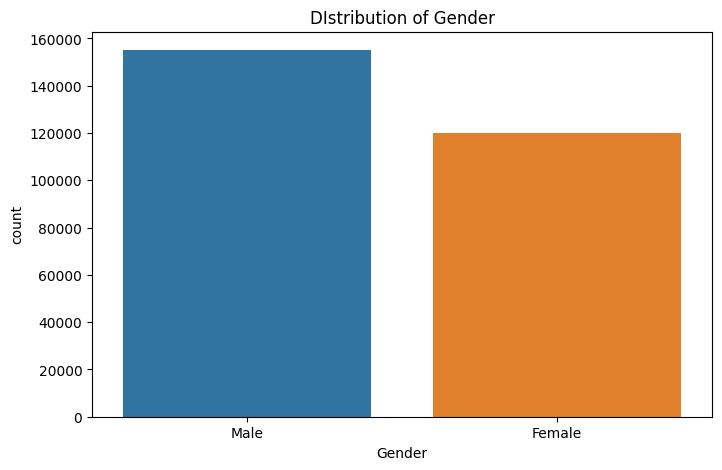

In [10]:
categorical_columns = data.select_dtypes(include='object').columns
for column in categorical_columns:
        plt.figure(figsize=(8,5))
        sns.countplot(x=column, data=df)
        plt.title(f'DIstribution of {column}')
        plt.show()

* 프랑스 > 스페인 > 독인 순으로 많음
* 남자가 더 많음

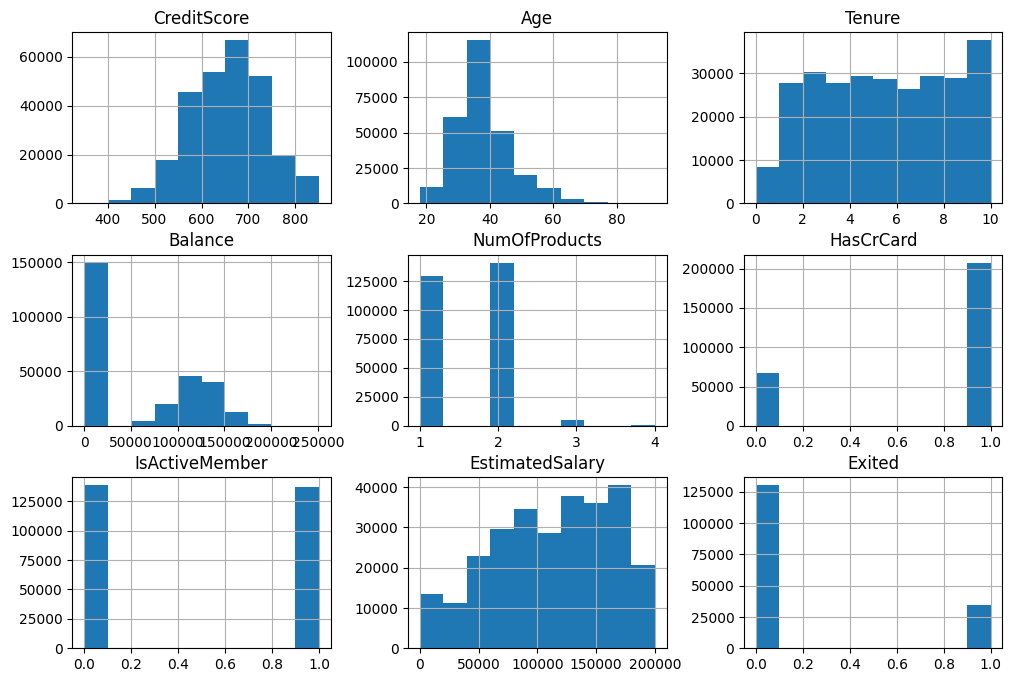

In [11]:
data.hist(figsize=(12,8))
plt.show()

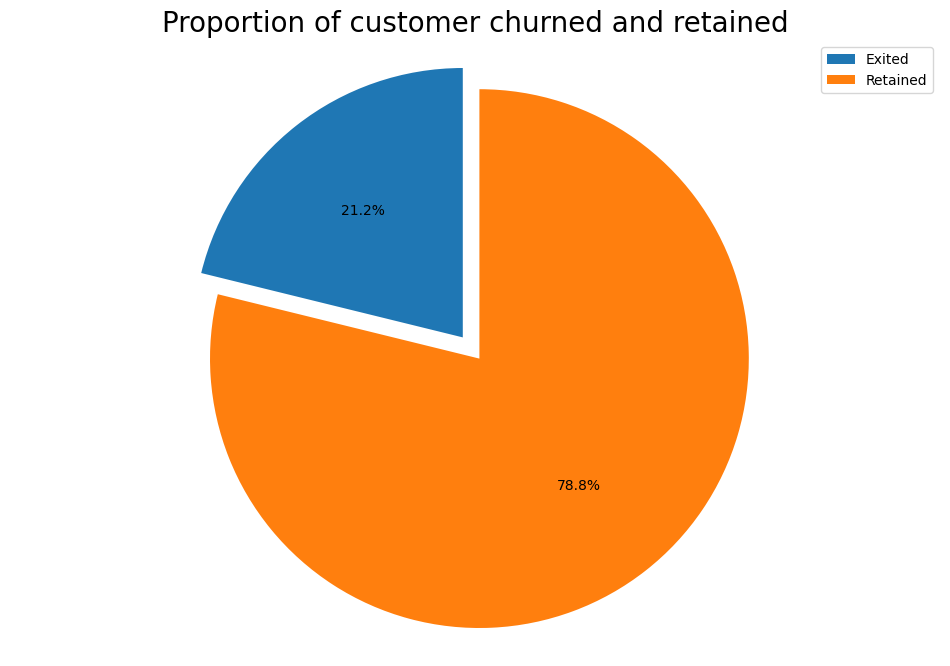

In [12]:
lables='Exited', 'Retained'
sizes=[data.Exited[data['Exited']==1].count(), data.Exited[data['Exited']==0].count()]
explode=(0,0.1)
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.legend(['Exited', 'Retained'])
plt.show()

* 신용점수는 평균 600~700점대
* 가입 연령 30대가 다수
* 가입 기간: 1년 이상부터 비슷하나 10년 정도의 장기 고객이 다수
* 평균 잔액: 5500유로
* 상품 갯수는 2개가 가장 많음
* 신용카드 사용자가 20만명
* 활성 고객: 12만 5천명대
* 추정 연봉: 11만 24백 유로
* 이탈고객: 16만명 (21.2%)


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


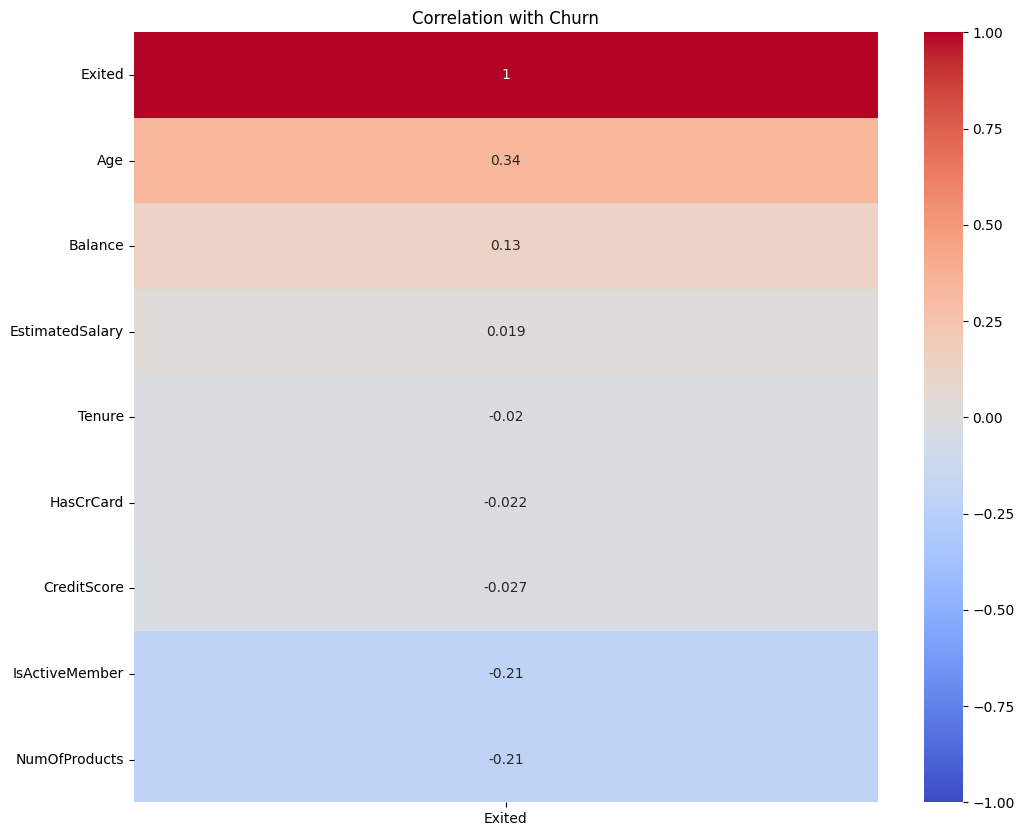

In [13]:
correlation_matrix = data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[['Exited']].sort_values(by='Exited', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Churn')
plt.show()

* 나이 > 잔액 > 추정연봉에 따른 순으로 이탈율과 관련됨을 알 수 있음

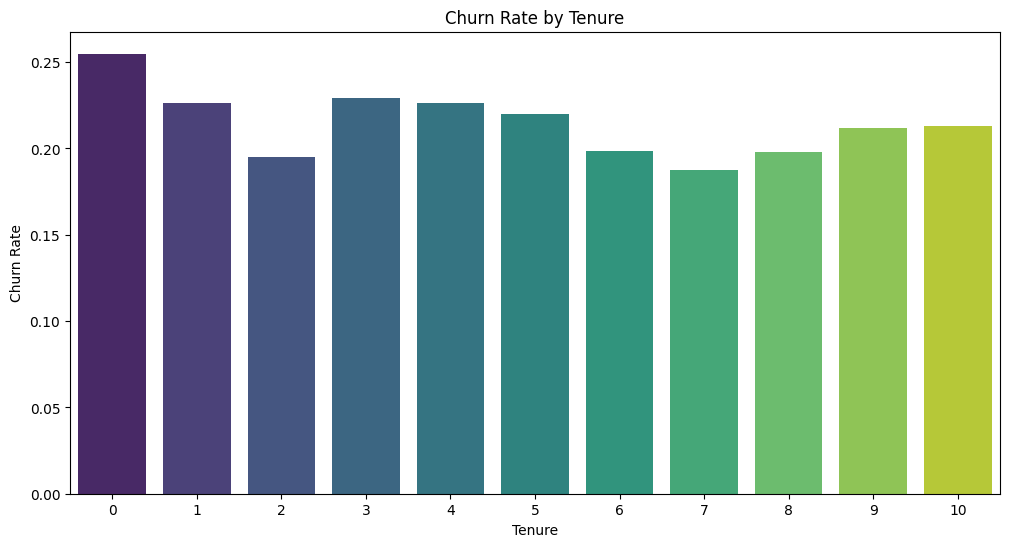

In [14]:
tenure_exit_rate = data.groupby('Tenure')['Exited'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Tenure', y='Exited', data=tenure_exit_rate, palette='viridis')
plt.title('Churn Rate by Tenure')
plt.xlabel('Tenure')
plt.ylabel('Churn Rate')
plt.show()

* 가입 기간이 1년 미만일 수록 이탈률이 가장 높고, 3~5년 사이가 다시 높아지는 시기

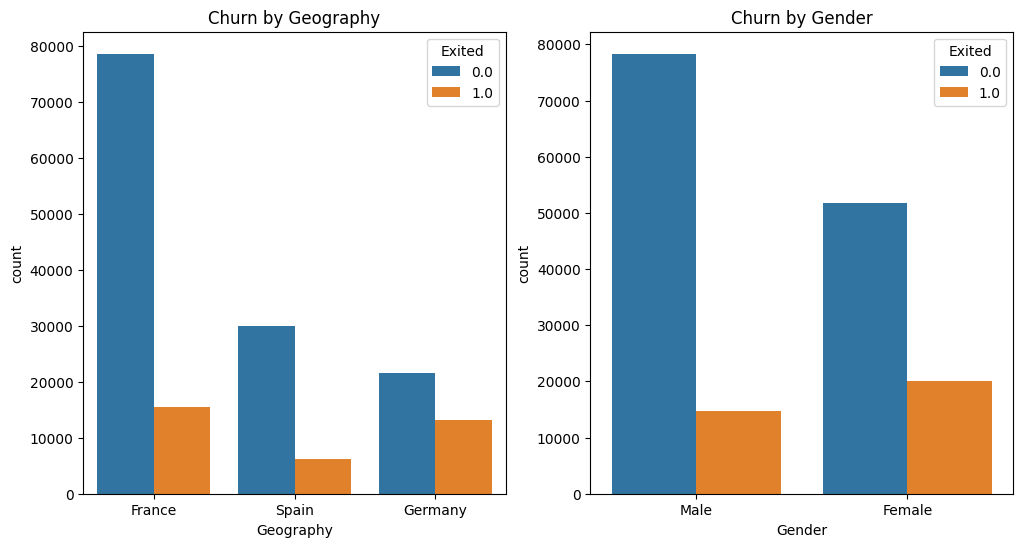

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Geography', hue='Exited', data=data)
plt.title('Churn by Geography')

plt.subplot(1, 2, 2)
sns.countplot(x='Gender', hue='Exited', data=data)
plt.title('Churn by Gender')

plt.show()

* 프랑스, 독일, 스페인 순으로 이탈율 높음
* 남성보다 여성이 이탈율이 높음

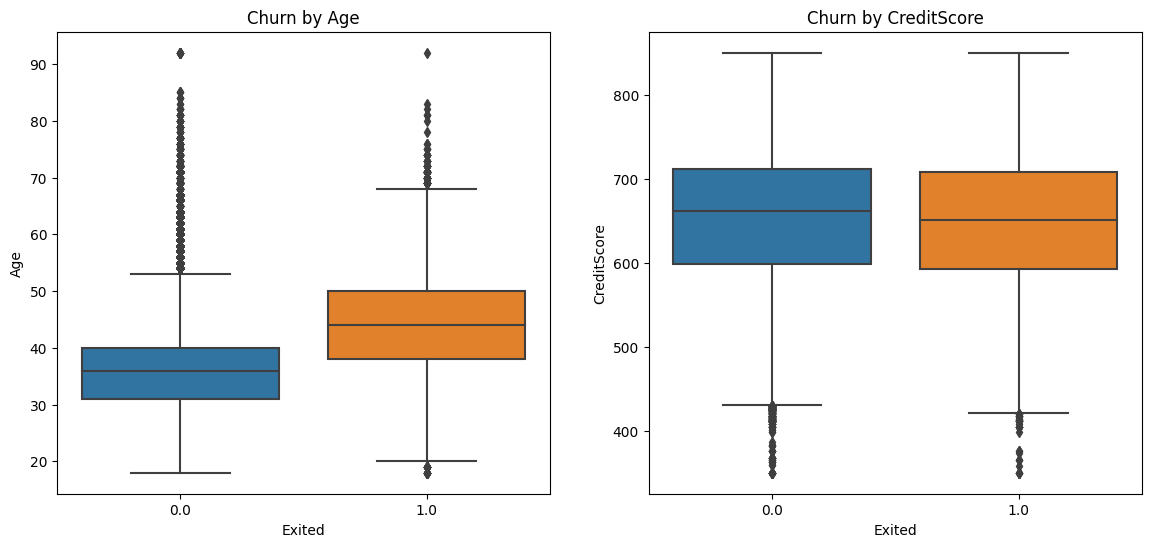

In [16]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Exited', y='Age', data=data)
plt.title('Churn by Age')

plt.subplot(1, 2, 2)
sns.boxplot(x='Exited', y='CreditScore', data=data)
plt.title('Churn by CreditScore')

plt.show()

* 40~50대애서 많이 이탈
* 신용 점수는 이탈율에 거의 영향을 끼치지 않음

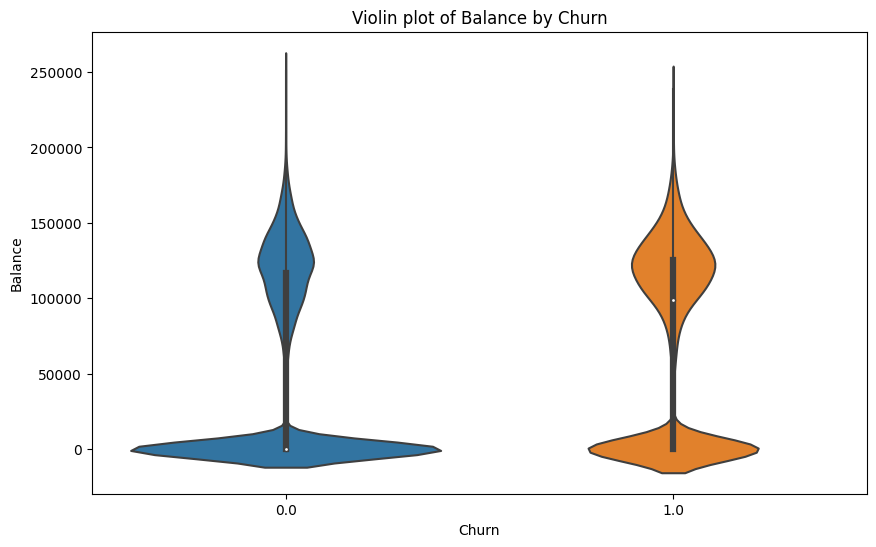

In [23]:
# 이탈 여부 시각화
plt.figure(figsize=(10, 6))
sns.violinplot(x='Exited', y='Balance', data=data)
plt.title('Violin plot of Balance by Churn')
plt.xlabel('Churn')
plt.ylabel('Balance')
plt.show()


* Exited 의 대부분은 잔액이 0원, 잔액이 12만유로가 있으나 이탈


Text(0, 0.5, 'Average Salary')

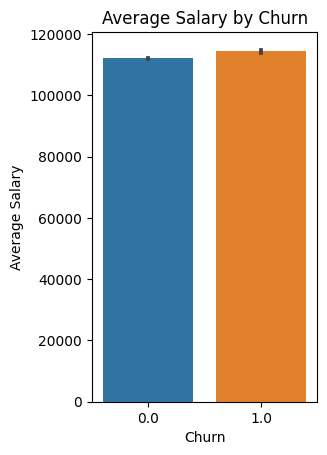

In [18]:
plt.subplot(1, 2, 1)
sns.barplot(x='Exited', y='EstimatedSalary', data=data)
plt.title('Average Salary by Churn')
plt.xlabel('Churn')
plt.ylabel('Average Salary')


* 소득에 따른 차이는 별로 없음

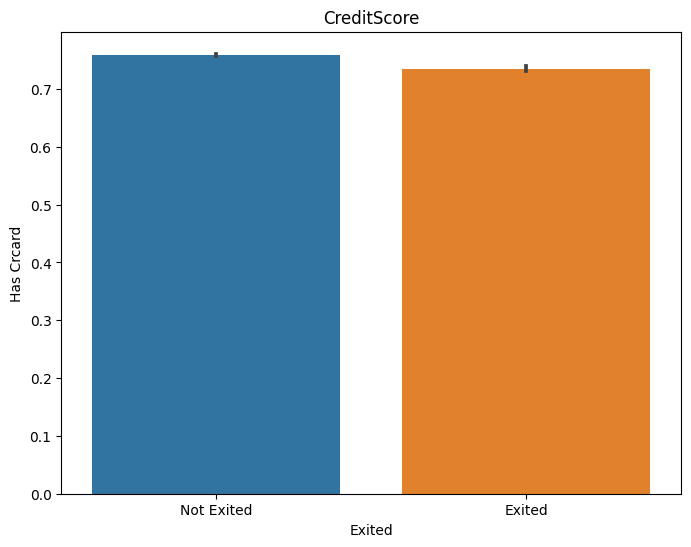

In [34]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Exited', y='HasCrCard', data=data)
plt.title('CreditScore')
plt.xlabel('Exited')
plt.ylabel('Has Crcard')
plt.xticks(ticks=[0, 1], labels=['Not Exited', 'Exited'])
plt.show()

* 신용카드 이용자 보다 그렇지 않은 사람이 더 많이 이탈함